In [266]:
from pathlib import Path

import geopandas as gpd
import pandas as pd
import numpy as np
import pdal

import xarray as xr

from forest_structure_tools.z_metrics import z_metrics, z_metrics_xr

In [267]:
data_dir = Path("../data")
plots_dir = data_dir / "outputs" / "plots"
plots_lidar_dir = plots_dir / "lidar"

In [268]:
def read_plot(plot_id: str):
    file_path = plots_lidar_dir / f"{plot_id}.copc.laz"
    pl = pdal.Reader(str(file_path)).pipeline()
    pl.execute()
    return pl.arrays[0]

In [269]:
points = read_plot("ULO_188_P3")
z = points['Z']
x = points['X']
y = points['Y']
rn = points['ReturnNumber']
# veg_mask = z > 0.5

# z = z[veg_mask]
# x = x[veg_mask]
# y = y[veg_mask]

In [270]:
ds = z_metrics_xr(
    z, percentiles=[25, 50, 75], percentages=[('at', 0), ('above', 2)], zbin_size=1, k=1
)
ds

<xarray.Dataset> Size: 3kB
Dimensions:       (z: 47)
Coordinates:
  * z             (z) float64 376B 0.0 1.0 2.0 3.0 4.0 ... 43.0 44.0 45.0 46.0
Data variables: (12/20)
    max           float64 8B 45.07
    min           float64 8B 0.0
    range         float64 8B 45.07
    mean          float64 8B 15.95
    median        float64 8B 14.28
    sd            float64 8B 10.93
    ...            ...
    zbin_inside%  (z) float64 376B 10.3 3.329 1.821 ... 0.02368 0.0008772
    zbin_entries  (z) float64 376B 1.174e+04 1.553e+04 ... 1.14e+05 1.14e+05
    zbin_exits    (z) float64 376B nan 1.174e+04 1.553e+04 ... 1.14e+05 1.14e+05
    zbin_ppi      (z) float64 376B nan 0.7557 0.8821 ... 0.9995 0.9998 1.0
    zbin_vad      (z) float64 376B nan 0.2801 0.1254 ... 0.0002369 8.772e-06
    vai           float64 8B 2.273
Attributes:
    suffix:     None
    zbin_size:  1
    weighted:   False
    k:          1

In [271]:
points_xr = xr.Dataset(data_vars={
    "x": ("point_idx", x),
    "y": ("point_idx", y),
    "z": ("point_idx", z),
})

In [272]:
grain_size = 10

x_bins = np.arange(points_xr['x'].min(), points_xr['x'].max() + grain_size, grain_size)
y_bins = np.arange(points_xr['y'].min(), points_xr['y'].max() + grain_size, grain_size)

xy_group = points_xr.groupby(x=xr.groupers.BinGrouper(bins=x_bins, labels=x_bins[:-1], include_lowest=True), y=xr.groupers.BinGrouper(bins=y_bins, labels=y_bins[:-1], include_lowest=True))

def my_map(ds: xr.Dataset):
    
    z = ds.z
    return z_metrics_xr(
        z, include_basic_metrics=True, zbin_size=1
    )

xy_metrics = xy_group.map(my_map)
xy_metrics = xy_metrics.rename({ "x_bins": "x", "y_bins": "y"})

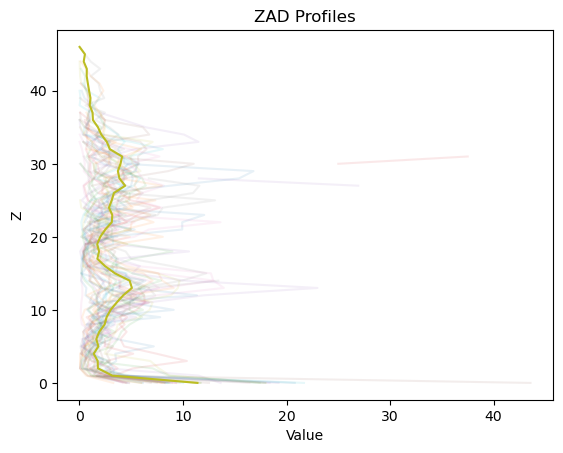

In [273]:
import matplotlib.pyplot as plt

# Assuming your DataArray is called da
da = xy_metrics['zbin_inside%']  # replace with your variable

fig, ax = plt.subplots()

# Loop through each (x, y) combination
for i, xval in enumerate(da.x.values):
    for j, yval in enumerate(da.y.values):
        profile = da.isel(x=i, y=j)
        if not np.all(np.isnan(profile)):  # skip all-NaN profiles
            ax.plot(profile, da.z, alpha=0.1)
ax.plot(da.mean(dim=['x', 'y']), da.z, alpha=1)

ax.set_xlabel("Value")
ax.set_ylabel("Z")
ax.set_title("ZAD Profiles")
# ax.legend(fontsize='small', ncol=2, bbox_to_anchor=(1.05, 1))
plt.show()